# Predicting House Prices in Ames, Iowa

This document show the general EDA, feature selection, and model predicting of a dataset of hosing prices in Ames, Iowa from Kaggle.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

In [2]:
# setting options for displays.
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [3]:
#loading data sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

## Combine Datasets for Clean Up

In order to clean up both data sets in the same way, it might be beneficial to add a boolean column indicating whether or not an observation belonged in the test or trainging dataset. 

In [6]:
#Create a new column on whether it's from the test set.
train['Test'] = 0
test['Test'] = 1
#make a SalePrice Column in test, just so that they are the same shape
test['SalePrice'] = 0.0

#concate the columns (stacks on stacks)
merged = pd.concat([train,test],axis=0).reset_index(drop=True)
merged['SalePrice'] = merged['SalePrice'].astype('float')


# Missingness

In [8]:
# Summarize the columns which have missing values and count how many there are in each
sum_missing_values = np.sum(merged.isnull())
sum_missing_values[sum_missing_values>0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

### Notes
We noticed there are a lot of missing values in the Pool, Fence, MiscFeature, and Alley.  These might be due to the fact that these houses might not have those features, so we could impute a string instead of an NA. Under futher inspection of the variables, here are some notes on what we can do to the missing values:

Most of the missing values are accounted for by the fact that there was an NA option in the categorical value, which was read as a null value in python.

- LotFrontage: impute 0
- Alley:  There is an option NA in the orignal categories. NA == No Alley Access. 
- MasVnrType: Impute None
- MasVnrArea: Impute 0
- BsmtQual -> BsmtFinType2:  No basement. (usually)  Impute for missing values
- Electrical: Impute Mode.
- FireplaceQu: # Fireplaces = 0; Impute None
- GarageType -> GarageCond:  No Garage. Garage cars = 0
- PoolQC: No pool --> Create bool feature?
- Fence: No Fence as part of original categories
- MiscFeature:  NA means no extra misc feature. 



In [10]:
#Imputing None values
rep_NA_col = ['Alley', 'FireplaceQu', 'Fence', 'MiscFeature', 'PoolQC', 'MasVnrType',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
              'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

for column_name in rep_NA_col:
    merged.loc[merged[column_name].isnull(), column_name] = 'None'

In [11]:
#LotFrontage, MasVnrArea, GarageArea, GarageCars, etc. -> 0
rep_NA_col = ['LotFrontage','MasVnrArea', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
             'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 
              'TotalBsmtSF']

for column_name in rep_NA_col:
    merged.loc[merged[column_name].isnull(), column_name] = 0


In [12]:
#impute mode: (There was not a lot of variation in the values; overwhelming mode value)
merged.loc[merged['Electrical'].isnull(), 'Electrical'] = 'SBrkr' #mode
merged.loc[merged['Exterior1st'].isnull(), 'Exterior1st'] = 'VinylSd' #mode
merged.loc[merged['Exterior2nd'].isnull(), 'Exterior2nd'] = 'VinylSd' #mode
merged.loc[merged['Functional'].isnull(), 'Functional'] = 'Typ' #mode
merged.loc[merged['KitchenQual'].isnull(), 'KitchenQual'] = 'TA' #mode
merged.loc[merged['MSZoning'].isnull(), 'MSZoning'] = 'RL' #mode
merged.loc[merged['SaleType'].isnull(), 'SaleType'] = 'WD' #mode
merged.loc[merged['Utilities'].isnull(), 'Utilities'] = 'AllPub' #mode


In [13]:
# Double check that there are no more missing values.
sum_missing_values = np.sum(merged.isnull())
sum_missing_values[sum_missing_values>0]

Series([], dtype: int64)

Now there are no missing values and we can start to examine which features are most highly correlated with sales price. 

# Feature Selection

In general, we want to decrease the number of features by eliminating features with a lower correlation than the Id feature (random noise) and by combining features which express similar information (size, quality, etc). 

First, we need to categorize the types of variables, including groups of ordinal variables which can be encoded into numeric values later.

In [14]:
#Make a list of all the types of variables in the data set.   
continuous = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
              'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
              'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
              'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']

nominal = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
           'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
           'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
           'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating',  'CentralAir', 'Electrical', 
           'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition',
           'Fence']

ordinal_num = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
               'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageCars', 'MoSold']

ordinal_names = ['LandSlope', #Gtl Mod Sev
                 'GarageFinish', #Unf RFn Fin None
                 'BsmtExposure'] #No Av Gd Mn None

ordinal_qualcond = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                    'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 
                    'GarageCond', 'PoolQC'] #Ex Ta Gd Fa Po None

ordinal = ordinal_num + ordinal_names + ordinal_qualcond

In [15]:
#Create dictionaries for ordinal variables and replace string lables with numerical values.
LandSlope_ord_dic = {'Gtl':1, 'Mod':2, 'Sev':3}
GarageFinish_ord_dic = {'None':0, 'Unf':1, 'RFn':2, 'Fin':3}
BsmtExposure_ord_dic = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
qualcond_ord_dic = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

merged.LandSlope.replace(LandSlope_ord_dic, inplace=True)
merged.GarageFinish.replace(GarageFinish_ord_dic, inplace=True)
merged.BsmtExposure.replace(BsmtExposure_ord_dic, inplace=True)
for feature in ordinal_qualcond:
    merged[feature].replace(qualcond_ord_dic, inplace=True)

In [16]:
#Check for very disproportionate variables for ordinal values.
for feature in ordinal:
    print(merged[feature].value_counts())


5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     31
2      13
1       4
Name: OverallQual, dtype: int64
5    1645
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
0.0    1707
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64
0.0    2744
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64
2    1530
1    1309
3      64
0      12
4       4
Name: FullBath, dtype: int64
0    1834
1    1060
2      25
Name: HalfBath, dtype: int64
3    1596
2     742
4     400
1     103
5      48
6      21
0       8
8       1
Name: BedroomAbvGr, dtype: int64
1    2785
2     129
0       3
3       2
Name: KitchenAbvGr, dtype: int64
6     844
7     649
5     583
8     347
4     196
9     143
10     80
11     32
3      25
12     16
15      1
13      1
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64
0    1420
1    1268
2     219
3      11
4       1
Name: Fireplaces, dtype: int64
2.0    1594
1.0   

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


/Users/jonpresley/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


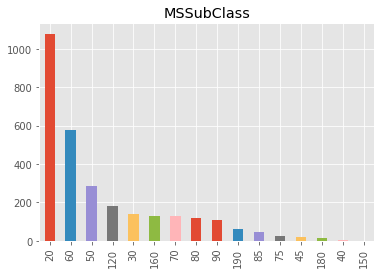

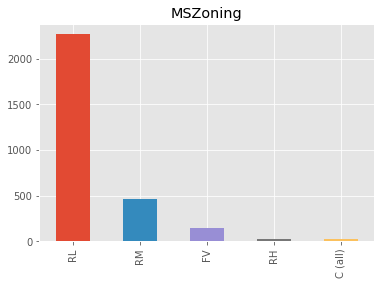

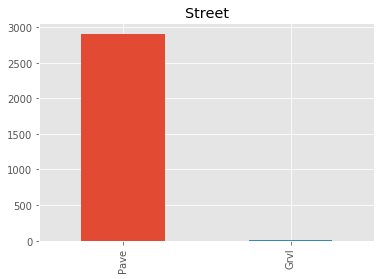

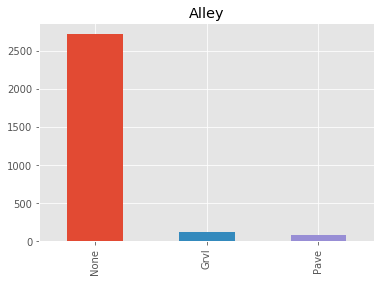

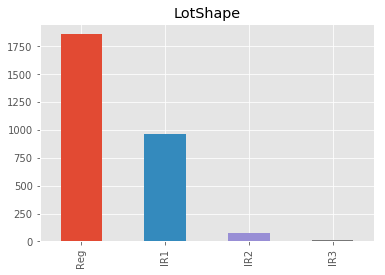

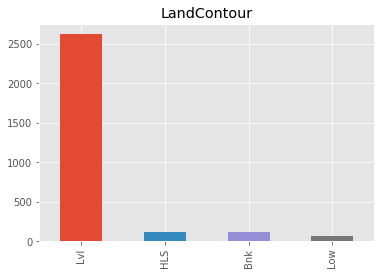

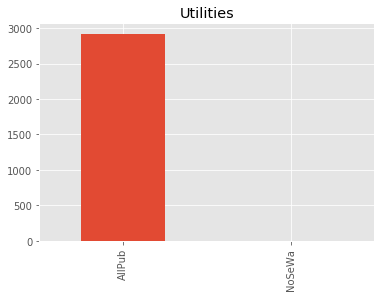

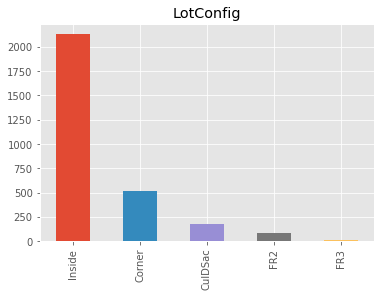

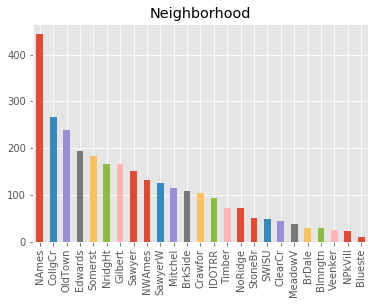

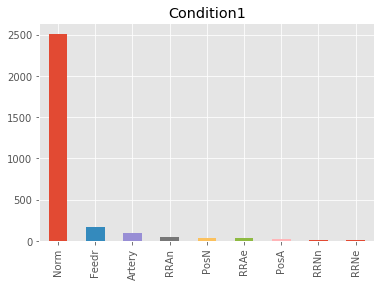

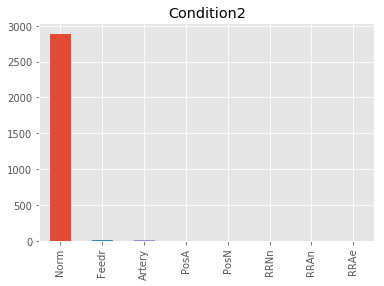

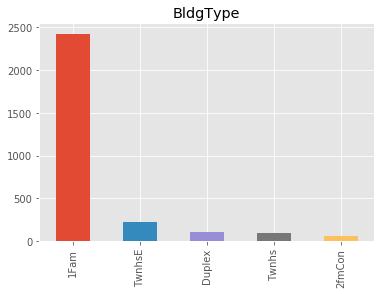

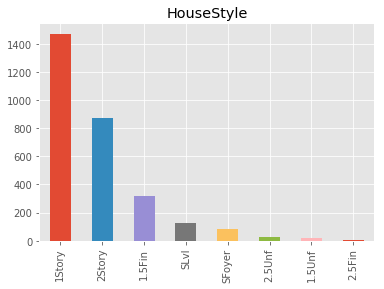

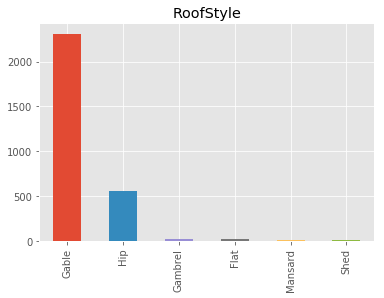

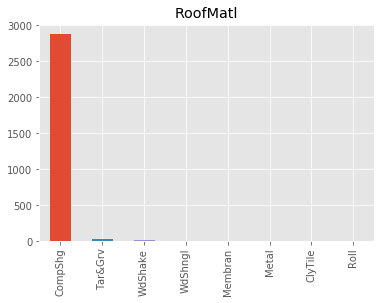

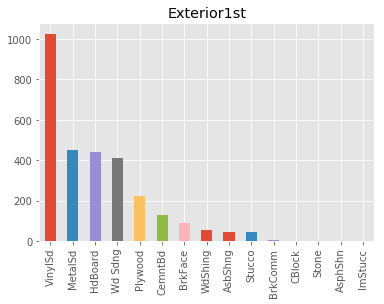

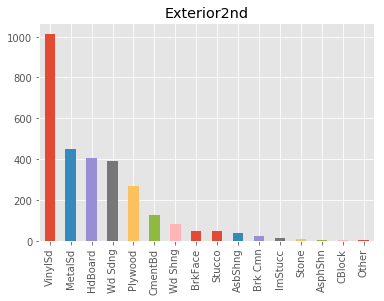

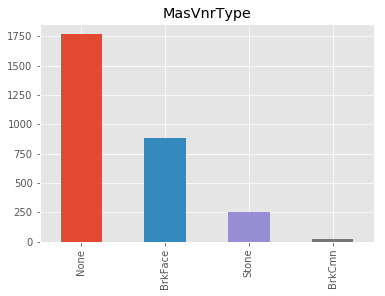

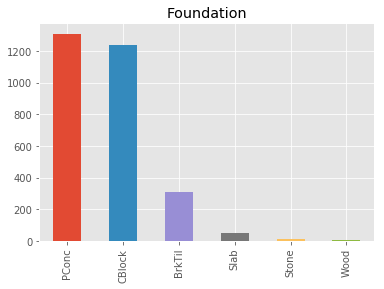

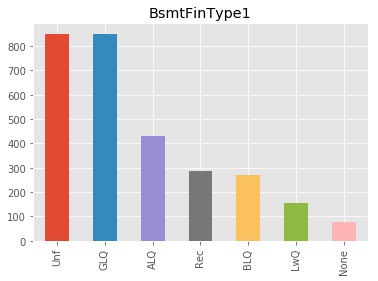

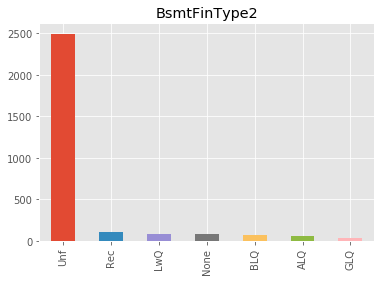

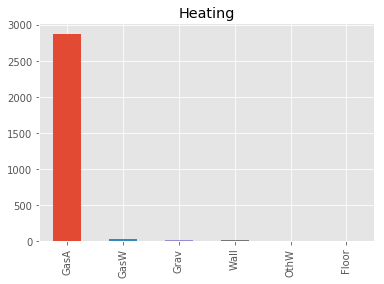

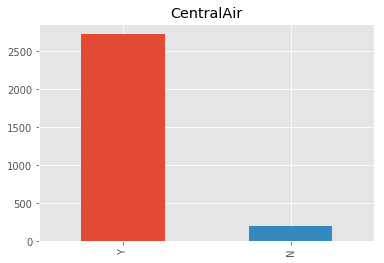

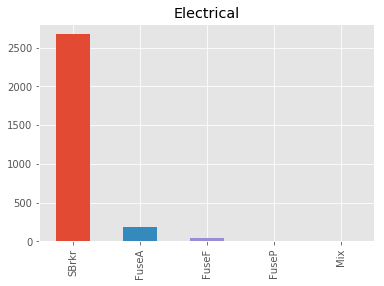

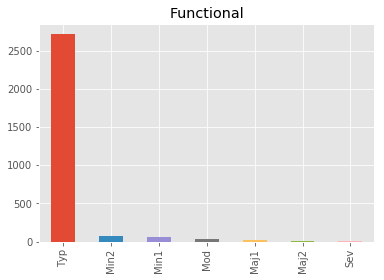

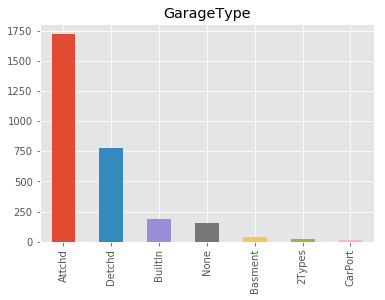

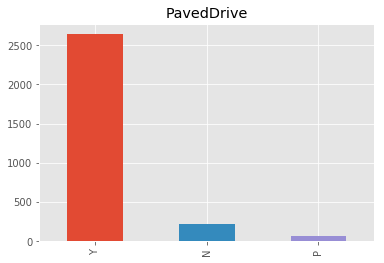

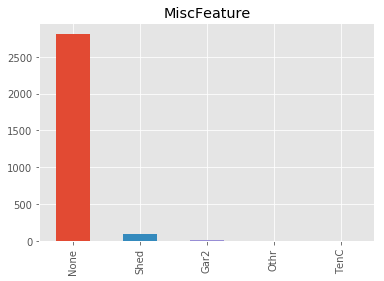

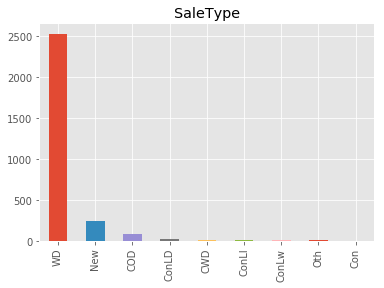

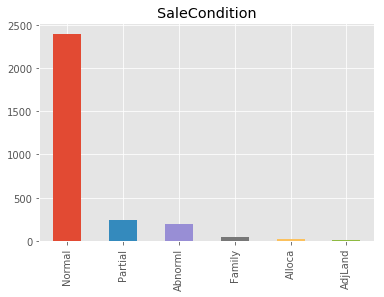

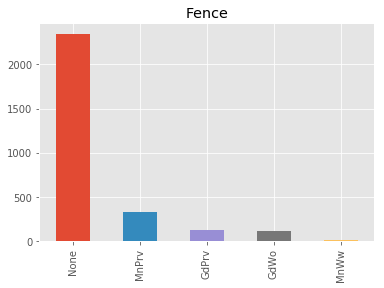

In [16]:
#Check for very disproportionate variables for nominal values.
for feature in nominal:
    plt.figure()
    print(merged[feature].value_counts().plot.bar())
    plt.title(feature)

In [17]:
#Drop Columns with Almost all one Input (very little range in values)
drop_col = ['Utilities', 'Street', 'Alley', 'Condition2', 'RoofMatl', 'PoolQC']
merged.drop(drop_col, axis=1, inplace=True)

In [18]:
#Combine squarefeet above ground
merged['TotalSF'] = merged['TotalBsmtSF'] + merged['1stFlrSF'] + merged['2ndFlrSF']
drop_var = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
merged.drop(drop_var, axis=1, inplace=True)

In [19]:
#Drop Garage Area (correlated with Garage SQFT)
merged.drop(['GarageArea'], axis=1, inplace=True)


In [20]:
#Combine the number of bathrooms
merged['TotalBath'] = merged['FullBath'] + merged['HalfBath']
drop_var = ['FullBath', 'HalfBath']
merged.drop(drop_var, axis=1, inplace=True)


In [21]:
#drop LowQualFinST because almost all 0
merged.drop(['LowQualFinSF'], axis=1, inplace=True)


In [22]:
#drop TotRmsAbvGrd because correlated with GrLivArea
#drop GarageYrBuilt because correlated with YearBuilt
merged.drop(['TotRmsAbvGrd'], axis=1, inplace=True)
merged.drop(['GarageYrBlt'], axis=1, inplace=True)


In [23]:
#Combine squarefeet basement
merged['BsmtSF'] = merged['BsmtFinSF1'] + merged['BsmtUnfSF'] + merged['BsmtFinSF2']
drop_var = ['BsmtFinSF1', 'BsmtUnfSF', 'BsmtFinSF2']
merged.drop(drop_var, axis=1, inplace=True)


In [24]:
#Combine basement bathroom
merged['BsmtBath'] = merged['BsmtFullBath'] + merged['BsmtHalfBath']
drop_var = ['BsmtFullBath', 'BsmtHalfBath']
merged.drop(drop_var, axis=1, inplace=True)


In [25]:
#Combine outdoor space
merged['OutdoorSF'] = merged['WoodDeckSF'] + merged['OpenPorchSF'] + merged['EnclosedPorch'] + merged['3SsnPorch'] + merged['ScreenPorch']
drop_var = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
merged.drop(drop_var, axis=1, inplace=True)


In [26]:
# Split back into Train and Test dataframes to check for correlation between inputs and SalePrice.
train1 = merged[merged['Test'] == 0]
train1.drop(columns=['Test'],inplace=True)
test1 = merged[merged['Test'] == 1]
test1.drop(columns=['Test','SalePrice'],inplace=True)

/Users/jonpresley/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


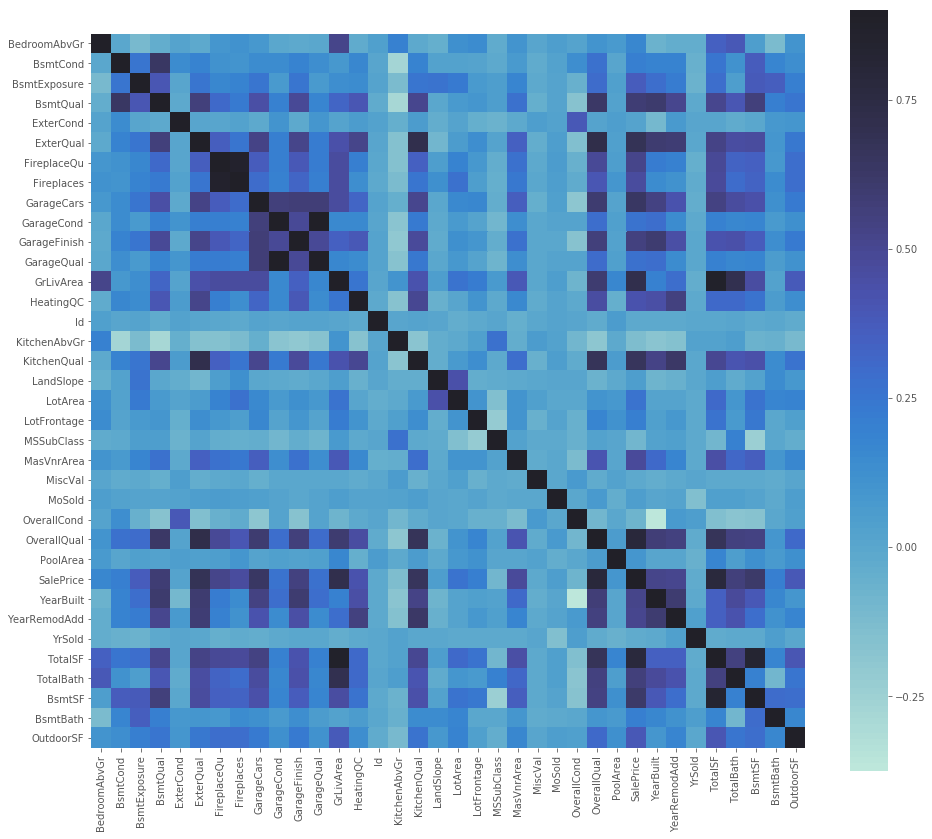

In [27]:
# Heatmap of corrations between numerical features.
corr = train1.corr()
plt.subplots(figsize=(16,14))
sns.heatmap(corr, vmax=0.9, square=True, center=1)

In [29]:
# Sorted list of features correlated with SalePrice.
correlations_sorted = train1.corr().abs()['SalePrice'].sort_values(ascending=False)
correlations_sorted

SalePrice       1.000000
OverallQual     0.790982
TotalSF         0.782260
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
BsmtSF          0.613581
BsmtQual        0.585207
TotalBath       0.568267
GarageFinish    0.549247
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
HeatingQC       0.427649
OutdoorSF       0.390993
BsmtExposure    0.374696
GarageQual      0.273839
LotArea         0.263843
GarageCond      0.263191
BsmtCond        0.212607
BsmtBath        0.211520
LotFrontage     0.209624
BedroomAbvGr    0.168213
KitchenAbvGr    0.135907
PoolArea        0.092404
MSSubClass      0.084284
OverallCond     0.077856
LandSlope       0.051152
MoSold          0.046432
YrSold          0.028923
Id              0.021917
MiscVal         0.021190
ExterCond       0.018899
Name: SalePrice, dtype: float64

In [29]:
# All correlation values to check values for correlation between features.
train1.corr().abs()

,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtQual,ExterCond,ExterQual,FireplaceQu,Fireplaces,GarageCars,GarageCond,GarageFinish,GarageQual,GrLivArea,HeatingQC,Id,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,MSSubClass,MasVnrArea,MiscVal,MoSold,OverallCond,OverallQual,PoolArea,SalePrice,YearBuilt,YearRemodAdd,YrSold,TotalSF,TotalBath,BsmtSF,BsmtBath,OutdoorSF
BedroomAbvGr,1.000000,0.001996,0.115806,0.039913,0.015065,0.018729,0.094158,0.107570,0.086106,0.006145,0.011695,0.004645,0.521270,0.026869,0.037719,0.198597,0.018012,0.048196,0.119690,0.144494,0.023438,0.102775,0.007767,0.046544,0.012980,0.101676,0.070703,0.168213,0.070651,0.040581,0.036014,0.354034,0.395113,0.050450,0.124642,0.104568
BsmtCond,0.001996,1.000000,0.255687,0.633713,0.144756,0.185046,0.115439,0.102507,0.142644,0.144617,0.183516,0.128744,0.083536,0.171797,0.010085,0.268024,0.182535,0.026608,0.031349,0.015334,0.015839,0.073210,0.023240,0.025060,0.132361,0.268759,0.008098,0.212607,0.183115,0.188027,0.060289,0.254302,0.114073,0.372530,0.179617,0.136458
BsmtExposure,0.115806,0.255687,1.000000,0.399339,0.005713,0.249101,0.166902,0.186291,0.252830,0.072100,0.251367,0.076878,0.130377,0.150852,0.017320,0.121961,0.254707,0.261883,0.228830,0.070921,0.051150,0.175111,0.017281,0.019911,0.056732,0.296517,0.042190,0.374696,0.289623,0.221405,0.064060,0.291441,0.046761,0.383291,0.361233,0.210321
BsmtQual,0.039913,0.633713,0.399339,1.000000,0.019297,0.565558,0.307337,0.229635,0.449194,0.192805,0.485184,0.182236,0.327956,0.397169,0.028425,0.277731,0.510938,0.007085,0.072336,0.092717,0.051122,0.277490,0.044404,0.015662,0.164996,0.629379,0.026415,0.585207,0.602797,0.515013,0.021461,0.514299,0.402491,0.564299,0.209568,0.252543
ExterCond,0.015065,0.144756,0.005713,0.019297,1.000000,0.009184,0.005723,0.027900,0.009377,0.103940,0.016011,0.094924,0.016573,0.055520,0.029860,0.050350,0.057592,0.039610,0.014732,0.046807,0.064686,0.018065,0.051649,0.027244,0.389163,0.013953,0.044387,0.018899,0.103925,0.074745,0.008053,0.009376,0.023698,0.005872,0.080136,0.089108
ExterQual,0.018729,0.185046,0.249101,0.565558,0.009184,1.000000,0.361798,0.249335,0.526390,0.214680,0.519054,0.219023,0.435986,0.520027,0.005039,0.151236,0.716122,0.086525,0.055570,0.127864,0.016178,0.345329,0.039310,0.042790,0.138942,0.726278,0.034766,0.682639,0.598160,0.587318,0.006745,0.533779,0.458033,0.470580,0.095132,0.242740
FireplaceQu,0.094158,0.115439,0.166902,0.307337,0.005723,0.361798,1.000000,0.863241,0.370034,0.210507,0.394891,0.221797,0.469947,0.207500,0.001760,0.154811,0.353806,0.051922,0.185332,0.084423,0.039201,0.274950,0.020872,0.054470,0.056899,0.490788,0.048737,0.520438,0.224545,0.196103,0.051293,0.487521,0.333623,0.347615,0.083082,0.289481
Fireplaces,0.107570,0.102507,0.186291,0.229635,0.027900,0.249335,0.863241,1.000000,0.300789,0.198003,0.324376,0.208556,0.461679,0.129689,0.019772,0.123936,0.256409,0.123995,0.271364,0.044018,0.045569,0.247015,0.001409,0.046357,0.023820,0.396765,0.095074,0.466929,0.147716,0.112581,0.024096,0.477765,0.297691,0.339519,0.145845,0.289782
GarageCars,0.086106,0.142644,0.252830,0.449194,0.009377,0.526390,0.370034,0.300789,1.000000,0.568408,0.579729,0.576622,0.467247,0.325347,0.016570,0.050634,0.509810,0.002683,0.154871,0.165229,0.040110,0.361945,0.043080,0.040522,0.185758,0.600671,0.020934,0.640409,0.537850,0.420622,0.039117,0.536413,0.464135,0.434585,0.117893,0.237004
GarageCond,0.006145,0.144617,0.072100,0.192805,0.103940,0.214680,0.210507,0.198003,0.568408,1.000000,0.481813,0.959172,0.153327,0.155348,0.008607,0.181559,0.232077,0.015895,0.076097,0.013047,0.089846,0.133749,0.001663,0.012968,0.016706,0.286955,0.035739,0.263191,0.291096,0.144088,0.008895,0.199888,0.167092,0.176578,0.072063,0.121324


# Revisit Feature Selection

In [30]:
#create Pool Boolean variable 
merged['Pool'] = np.where(merged['PoolArea']>0, 1, 0)
merged.drop(['PoolArea'], axis=1, inplace=True) #less correlated to SalePrice than boolean

In [31]:
#drop values which are lower corr than ID because it's noise. (Retrospectively)
merged.drop(['MiscVal', 'ExterCond'], axis=1, inplace=True)

# Dummify

In [32]:
#Dummify the Categorical Variables.
for variable in list(set(nominal)-set(drop_col)):
    dummy = pd.get_dummies(merged[variable], prefix=variable, prefix_sep='_')
    dummy.drop(list(dummy.columns)[0], axis=1, inplace=True) #Drop 1st dummy is the dominant category
    merged.drop(variable, axis=1, inplace=True) #Drop original categorical column
    merged = pd.concat([merged, dummy], axis=1) #concat train with dummy dataframes

In [33]:
#Split the newly edited merged dataframe into train and test to check for correlation again.
train2 = merged[merged['Test'] == 0]
train2.drop(columns=['Test'],inplace=True)
test2 = merged[merged['Test'] == 1]
test2.drop(columns=['Test'],inplace=True)

/Users/jonpresley/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Outliers and Skewness

/Users/jonpresley/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


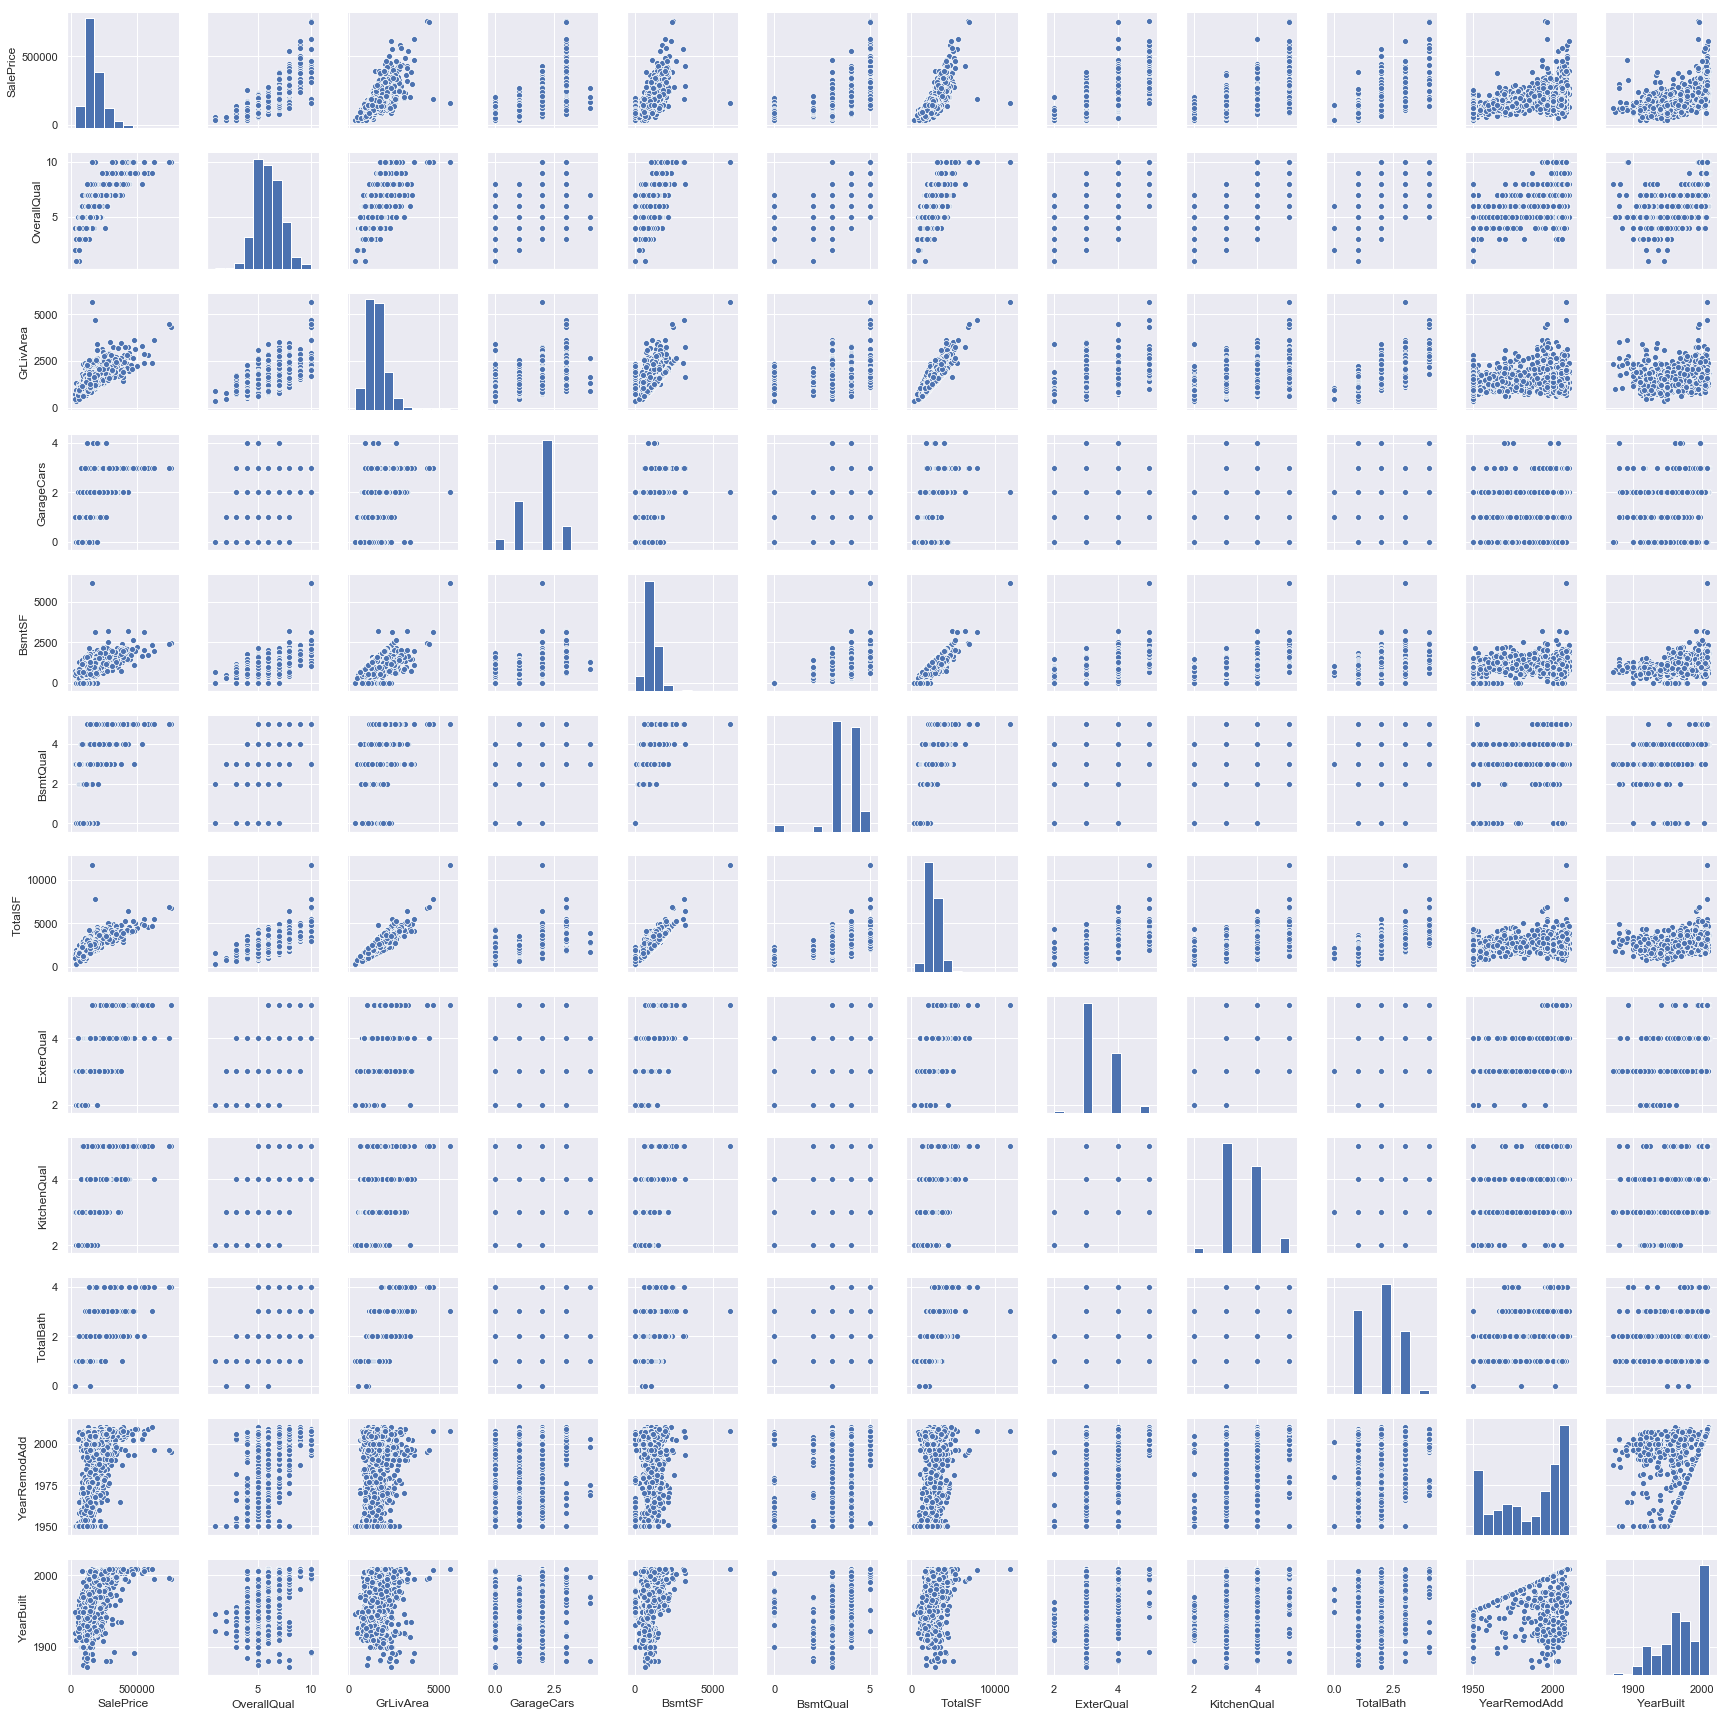

In [36]:
# Check for outliers and skewness for top correlated variables to SalePrice.
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'BsmtSF', 'BsmtQual', 
        'TotalSF', 'ExterQual', 'KitchenQual', 'TotalBath', 'YearRemodAdd', 'YearBuilt']

sns.pairplot(train2[cols], size = 2)
sns.set(font_scale=1.50)
plt.show()


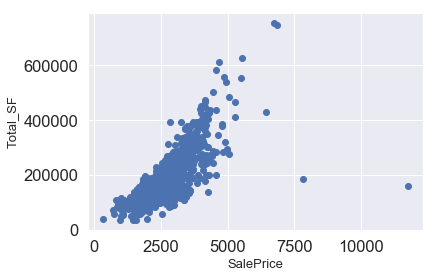

In [37]:
# There are outliers for Total_SF
fig, ax = plt.subplots()
ax.scatter(x = train2['TotalSF'], y = train2['SalePrice'])
plt.ylabel('Total_SF', fontsize=13)
plt.xlabel('SalePrice', fontsize=13)
plt.show()

In [34]:
#drop outliers from GrLivArea
train2.drop(train2[(train2['GrLivArea'] > 4000) & (train2['SalePrice'] < 300000)].index, inplace=True)


/Users/jonpresley/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


/Users/jonpresley/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180932.92 and sigma = 79467.79



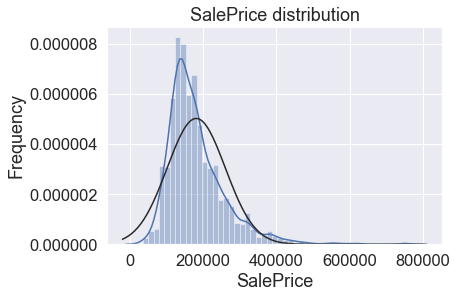

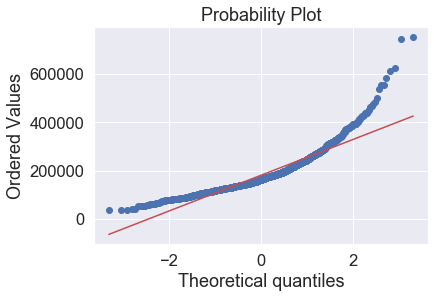

In [39]:
from scipy import stats
from scipy.stats import norm, skew
sns.distplot(train2['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train2['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plot the distribution

plt.ylabel('Frequency')
#plt.savefig("SalePrice Skewed.png",bpi=300, bbox_inches='tight')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train2['SalePrice'], plot=plt)
#plt.savefig("./SalePrice Skewed QQ.png",bpi=300, bbox_inches='tight')
plt.show()

# SKEWED RIGHT!

In [35]:
# taking the log of SalePrice to correct the skewness.

train2['SalePrice'] = np.log(train2['SalePrice'])

/Users/jonpresley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/jonpresley/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


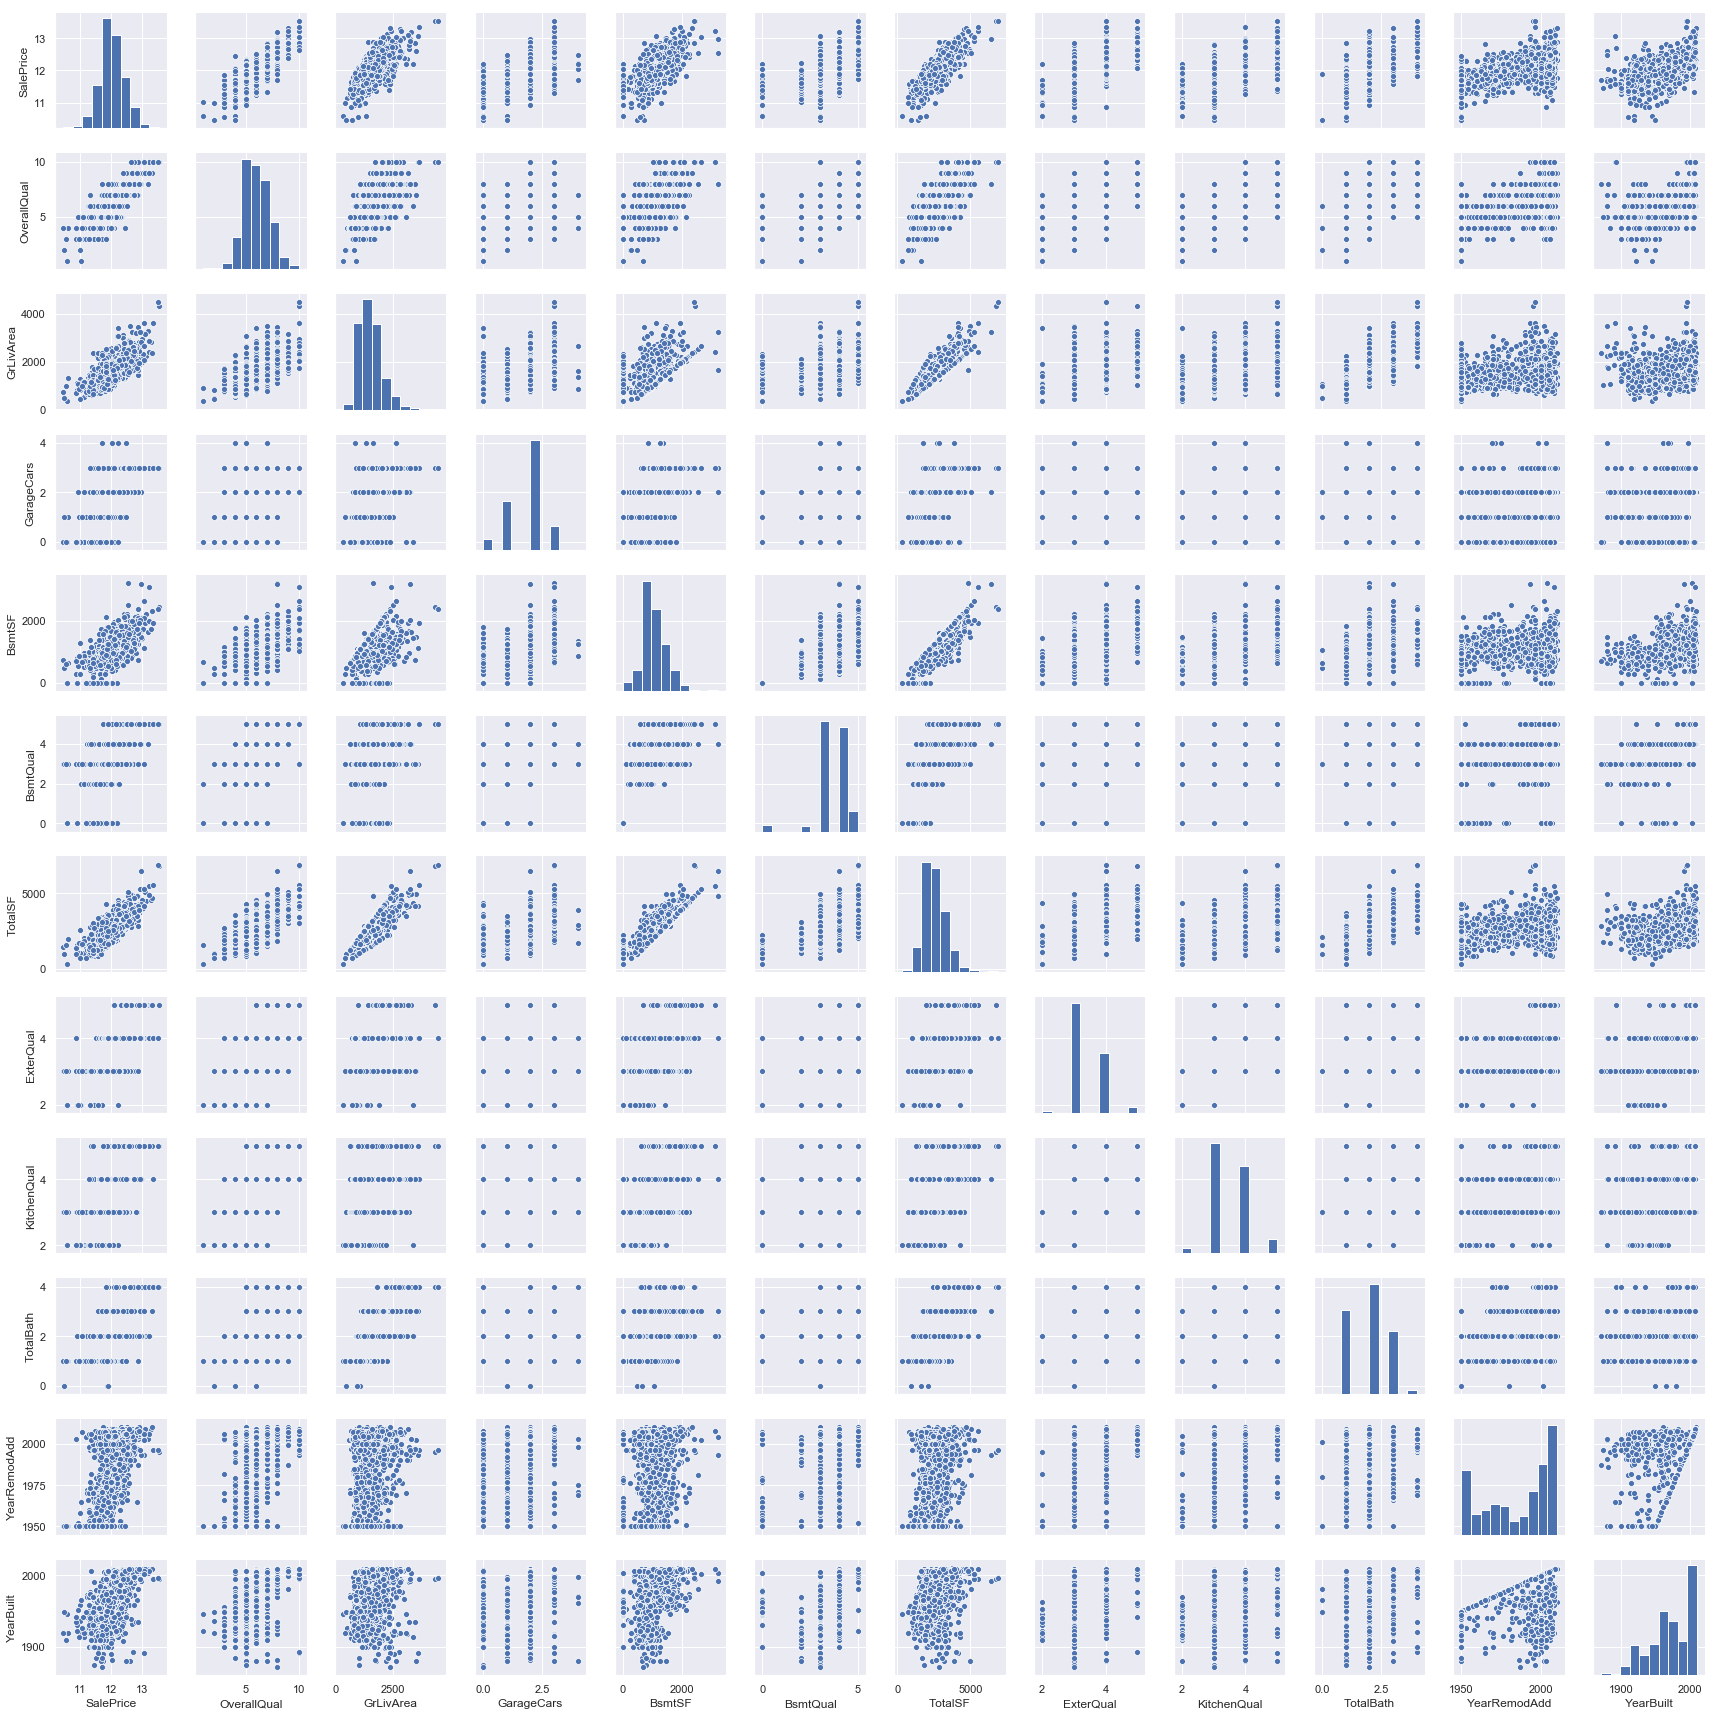

In [41]:
# Double check for skewness and outliers.
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'BsmtSF', 'BsmtQual', 
        'TotalSF', 'ExterQual', 'KitchenQual', 'TotalBath', 'YearRemodAdd', 'YearBuilt']

sns.pairplot(train2[cols], size = 2)
sns.set(font_scale=1.50)
plt.show()

In [37]:
#  Check out the correlations again and look for a good cutoff for which variables to keep.
correlations_sorted2 = train2.corr().abs()['SalePrice'].sort_values(ascending=False)
correlations_sorted2

SalePrice                1.000000
TotalSF                  0.825326
OverallQual              0.821404
GrLivArea                0.725211
ExterQual                0.682225
GarageCars               0.681033
KitchenQual              0.669989
BsmtSF                   0.647563
BsmtQual                 0.616897
TotalBath                0.612225
GarageFinish             0.605602
YearBuilt                0.587043
YearRemodAdd             0.565992
FireplaceQu              0.546791
Foundation_PConc         0.531193
Fireplaces               0.491998
HeatingQC                0.473938
BsmtFinType1_GLQ         0.441363
MasVnrArea               0.430569
GarageType_Attchd        0.416377
MSSubClass_60            0.402376
OutdoorSF                0.399695
GarageType_Detchd        0.388681
MasVnrType_None          0.388094
GarageQual               0.363258
BsmtExposure             0.358410
GarageCond               0.356766
Neighborhood_NridgHt     0.351850
CentralAir_Y             0.351598
MSZoning_RM   

# Prepare for Modeling

In order to prepare for the modeling code, we need to create dataframes with features that are more highly correlated than the Id column, separate the features with the target variable for the train dataset, and have a matching test set for prediction.

In [45]:
# only include columns which are more highly correlated than the Id column (about 0.02)
train3 = train2[correlations_sorted2[correlations_sorted2>0.02].index.values]
test3 = test2[correlations_sorted2[correlations_sorted2>0.02].index.values].drop(['SalePrice'], axis=1)

In [46]:
#import sklearn
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split

# separate the target from the inputs in the train dataset.
train4 = train3.copy()
train4_inputs = train3.drop(['SalePrice'], axis=1)
train4_target = train3['SalePrice']

#Splitting train data
X_train, X_test, y_train, y_test = train_test_split(train4_inputs, train4_target, test_size=0.2, random_state=0)


# Ridge

Since there seems to be signs of multicollinearity in the data, seen by the correlation matrix, penalized regression will help mitigate these violations of assumptions.  Also, since the data seems to have a linear relationship, as seen with worse outcomes with tree-based models, I'm fairly confident that penalized regression will result in the best predictive performance.

In [55]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
import datetime

In [51]:
#Kaggle Score 0.12223
#The model score is 93.14%
#Train RMSE: 10.38%
#Test RMSE: 10.72%
#Diff in RMSE: 0%

ridcv = RidgeCV(alphas=np.linspace(1e-5,30,10000), normalize=False, scoring=None)

ridcv.fit(X_train,y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=ridcv.predict(X_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=ridcv.predict(X_test)))

print('The best alpha is: {:.6}\n\nThe ridge intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    ridcv.alpha_,ridcv.intercept_, pd.Series(ridcv.coef_, index=X_train.columns), ridcv.score(X_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))


The best alpha is: 14.4434

The ridge intercept is: 15.84

TotalSF                  0.000083
OverallQual              0.046975
GrLivArea                0.000191
ExterQual                0.008131
GarageCars               0.031945
KitchenQual              0.023994
BsmtSF                   0.000019
BsmtQual                 0.006984
TotalBath                0.030276
GarageFinish             0.002113
YearBuilt                0.001613
YearRemodAdd             0.000618
FireplaceQu              0.004176
Foundation_PConc         0.025451
Fireplaces               0.020487
HeatingQC                0.010976
BsmtFinType1_GLQ         0.014762
MasVnrArea               0.000049
GarageType_Attchd        0.022105
MSSubClass_60           -0.004674
OutdoorSF                0.000110
GarageType_Detchd        0.017114
MasVnrType_None          0.009935
GarageQual               0.018131
BsmtExposure             0.015123
GarageCond               0.003583
Neighborhood_NridgHt     0.045396
CentralAir_Y           

In [56]:
# Save the predicitons in a csv file to submit to Kaggle. 
pd.DataFrame({'Id': test2['Id'], 'SalePrice': np.exp(ridcv.predict(test3))}
             ).to_csv('ridcv {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
                                            ), index=False)

# Lasso

Now let's try a lasso regression.

In [57]:
#Kaggle 0.12239
#The model score is 93.01%
#Train RMSE: 10.48%
#Test RMSE: 10.68%
#Diff in RMSE: 0%

lassocv = LassoCV(alphas=np.linspace(1e-4,1e-3,1000), normalize=False,
                      max_iter=10000, n_jobs=-1, cv=100)

lassocv.fit(X_train, y_train)

trainRMSE = np.sqrt(mean_squared_error(y_true=y_train, y_pred=lassocv.predict(X_train)))
testRMSE = np.sqrt(mean_squared_error(y_true=y_test, y_pred=lassocv.predict(X_test)))

print('The best alpha is: {:.6}\n\nThe lasso intercept is: {:.2f}\n\n{}\n\nThe model score is {:.2%}\n\nTrain RMSE: {:.2%}\n\nTest RMSE: {:.2%}\n\nDiff in RMSE: {:.0%}\n\n'.format(
    lassocv.alpha_,lassocv.intercept_, pd.Series(lassocv.coef_, index=X_train.columns), lassocv.score(X_train, y_train), trainRMSE,testRMSE,(testRMSE - trainRMSE)))



The best alpha is: 0.000436036

The lasso intercept is: 15.47

TotalSF                  0.000087
OverallQual              0.047857
GrLivArea                0.000188
ExterQual                0.006195
GarageCars               0.034277
KitchenQual              0.024050
BsmtSF                   0.000019
BsmtQual                 0.002732
TotalBath                0.027897
GarageFinish             0.000662
YearBuilt                0.001695
YearRemodAdd             0.000615
FireplaceQu              0.004387
Foundation_PConc         0.023956
Fireplaces               0.018453
HeatingQC                0.010099
BsmtFinType1_GLQ         0.010595
MasVnrArea               0.000049
GarageType_Attchd        0.006939
MSSubClass_60           -0.009151
OutdoorSF                0.000114
GarageType_Detchd        0.002203
MasVnrType_None          0.003988
GarageQual               0.021194
BsmtExposure             0.014688
GarageCond               0.000047
Neighborhood_NridgHt     0.060464
CentralAir_Y       

In [58]:
# Save to csv file for Lasso
pd.DataFrame({'Id':test2['Id'],'SalePrice': np.exp(lassocv.predict(test3))}
             ).to_csv('lasso {}.csv'.format(str(datetime.datetime.now())[:19].replace(':','.')
                                            ), index=False)